In [235]:
import numpy as np
from matplotlib import pyplot as plt
from helpers import normalize_dataset

In [236]:
def one_hot_encode(labels: np.ndarray):
    '''
    one-hot encode labels
    @param labels 1D array of labels
    
    @return one-hot encoded labels
    '''
    casted_labels = labels.astype(int)
    return np.eye(np.unique(casted_labels).shape[0])[casted_labels]

def reshape_flat_square_images(images: np.ndarray):
    '''
    reshape to be a grayscale square
    @param image N x TOTAL_PIXELS

    @return N x 1 x HEIGHT x WIDTH
    '''
    dims = np.sqrt(images.shape[1])
    if not dims.is_integer():
        raise ValueError('Image is not square')
    dims = int(dims)
    return images.reshape(images.shape[0], 1, dims, dims)

In [237]:
training = np.loadtxt("dataset/train.csv",
                 delimiter=",", dtype=str) # load training data
training_labels = one_hot_encode(training[1:, 0]) # first column is labels
training_data = reshape_flat_square_images(normalize_dataset(training[1:, 1:])) # rest of columns are data

# Training Samples: 38000
# Classes: 10
Image Height: 28
Image Width: 28


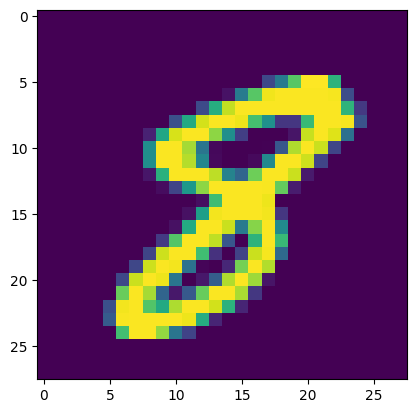

In [238]:
print("# Training Samples: " + str(training_labels.shape[0]))
print("# Classes: " + str(training_labels.shape[1]))
print("Image Height: " + str(training_data.shape[2]))
print("Image Width: " + str(training_data.shape[3]))
plt.imshow(training_data[0, 0]) # show first image in training set

In [239]:
# Forward Propagation Functions

def im2col(data: np.ndarray, conv: np.ndarray, stride: int, pad: int):
    '''
    transforms a batch of images into a matrix
    
    @param data N x 1 x HEIGHT x WIDTH input images
    @param conv NUM_FILTERS x 1 x CONV_HEIGHT x CONV_WIDTH convolutional layer
    @param stride number of pixels to move the filter each time
    @param pad number of pixels to pad the image with

    @return CONV_HEIGHT * CONV_WIDTH x NEW_WIDTH * NEW_HEIGHT * NUM_IMAGES
    '''
    data_padded = np.pad(data, ((0,0), (0,0), (pad, pad), (pad, pad)), mode='constant')
    num_images, num_channels, image_height, image_width = data_padded.shape
    conv_height = conv.shape[2]
    conv_width = conv.shape[3]
    output_height = int((image_height + (2 * pad) - conv_height) / stride) + 1
    output_width = int((image_width + (2 * pad) - conv_width) / stride) + 1
    
    # create a 4D view of the padded data to extract image patches
    # view has shape (num_images, num_channels, output_height, output_width, conv_height, conv_width)
    data_view = np.lib.stride_tricks.as_strided(data_padded,
                                                shape=(num_images, num_channels, output_height, output_width, conv_height, conv_width),
                                                strides=(data_padded.strides[0], data_padded.strides[1], 
                                                         stride * data_padded.strides[2], stride * data_padded.strides[3], 
                                                         data_padded.strides[2], data_padded.strides[3]))
    
    # reshape the view to a 2D array
    # the shape of the array is (num_images * output_height * output_width, num_channels * conv_height * conv_width)
    im2col_vector = data_view.reshape(num_images * output_height * output_width, num_channels * conv_height * conv_width)
    
    return im2col_vector.T # transpose the matrix to match the expected output shape

def convolve(data: np.ndarray, im2col_result: np.ndarray, conv: np.ndarray, stride: int):
    '''
    convolves the data with the im2col result
    @param data N x 1 x HEIGHT x WIDTH input images
    @param im2col_result CONV_HEIGHT * CONV_WIDTH x NEW_WIDTH * NEW_HEIGHT * NUM_IMAGES
    @param conv NUM_FILTERS x 1 x CONV_HEIGHT x CONV_WIDTH convolutional layer
    @param stride number of pixels to move the filter each time
    
    @return NUM_IMAGES x NUM_FILTERS x NEW_HEIGHT x NEW_WIDTH
    '''
    num_images, _, height, width = data.shape
    num_filters, _, conv_height, conv_width = conv.shape
    new_height = int(((height - conv_height) / stride)) + 1
    new_width = int(((width - conv_width) / stride)) + 1
    
    im2col_reshaped = im2col_result.reshape(conv_height * conv_width, new_width * new_height * num_images)
    conv_reshaped = conv.reshape(num_filters, -1)
    
    output = conv_reshaped @ im2col_reshaped
    output = output.reshape(num_images, num_filters, new_height, new_width)
    
    return output

def ReLU(x: np.ndarray):
    '''
    Rectified Linear Unit activation function
    
    @param x input to the activation function
    @return x if x > 0, 0 otherwise
    '''
    return (x > 0) * x

def maxpool_with_indices(data: np.ndarray, pool_size: int, stride: int):
    '''
    computes the maxpooling of the input data
    @param data N x CHANNELS x HEIGHT x WIDTH input images
    @param pool_size size of the pooling filter
    @param stride number of pixels to move the filter each time
    
    @return A tuple (max_output, indices) where:
            max_output is N x CHANNELS x NEW_HEIGHT x NEW_WIDTH
            indices is N x CHANNELS x NEW_HEIGHT x NEW_WIDTH x pool_size^2
    '''
    # Get input shape
    N, C, H, W = data.shape

    # Compute output shape
    OH = (H - pool_size) // stride + 1
    OW = (W - pool_size) // stride + 1

    # Pad input data to handle edge cases
    pad_height = ((OH - 1) * stride + pool_size - H) // 2
    pad_width = ((OW - 1) * stride + pool_size - W) // 2
    data = np.pad(data, ((0, 0), (0, 0), (pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Create view of data with desired strides
    data_strided = np.lib.stride_tricks.as_strided(data,
                                                shape=(N, C, OH, OW, pool_size, pool_size),
                                                strides=(data.strides[0],
                                                         data.strides[1],
                                                         stride * data.strides[2],
                                                         stride * data.strides[3],
                                                         data.strides[2],
                                                         data.strides[3]))

    # Compute max pooling and indices
    max_output = np.max(data_strided, axis=(4, 5))
    indices = np.argmax(data_strided, axis=4), np.argmax(data_strided, axis=5)
    indices = np.ravel_multi_index(indices, (pool_size, pool_size))
    idx_h, idx_w = np.unravel_index(indices, (pool_size, pool_size))
    idx_h = idx_h.reshape(N, C, OH, OW, -1)
    idx_w = idx_w.reshape(N, C, OH, OW, -1)
    indices = np.concatenate((idx_h, idx_w), axis=-1)
    
    return max_output, indices

def softmax(data: np.ndarray):
    '''
    Computes the softmax function for each row of the input x.
    @param data N x D matrix where N is the number of samples and D is the number of classes
    
    @return N x D matrix where each row is a valid probability distribution
    '''
    data_exp = np.exp(data-np.max(data))
    
    return data_exp / np.sum(data_exp, axis=0)

In [240]:
# Backpropagation Functions

def dReLU(x: np.ndarray):
    '''
    Derivative of the Rectified Linear Unit activation function
    @param x input to the activation function
    
    @return 1.0 if x > 0, 0 otherwise
    '''
    return (x > 0) * 1.0

def unpool_with_indices(delta_maxpool: np.ndarray, maxpool_indices: np.ndarray, pool_size: int):
    '''
    Unpools the given delta_maxpool using the maxpool_indices.
    @param delta_maxpool N x CHANNELS x HEIGHT x WIDTH array of max-pooled gradients
    @param maxpool_indices N x CHANNELS x NEW_HEIGHT x NEW_WIDTH x pool_size^2 array of indices
    @param pool_size size of the pooling filter used in the max-pooling operation
    
    @return delta_unpooled N x CHANNELS x (HEIGHT * pool_size) x (WIDTH * pool_size) array of unpooled gradients
    '''
    N, C, _, _, _ = maxpool_indices.shape
    _, _, H, W = delta_maxpool.shape

    delta_unpooled = np.zeros((N, C, H * pool_size, W * pool_size), dtype=delta_maxpool.dtype)

    for i in range(pool_size):
        for j in range(pool_size):
            mask = (maxpool_indices[..., 0] == i) & (maxpool_indices[..., 1] == j)
            delta_unpooled[..., i::pool_size, j::pool_size] += delta_maxpool * mask

    return delta_unpooled

In [241]:
num_filters = 2
conv_filter_size = 5
conv_stride = 1
conv_layer = np.random.randn(num_filters, 1, conv_filter_size, conv_filter_size) * np.sqrt(1. / conv_filter_size)
display(conv_layer.shape)

(2, 1, 5, 5)

In [242]:
single_im2col = im2col(training_data[0:1], conv_layer, conv_stride, 0) # only use one image
display(single_im2col.shape)

(25, 576)

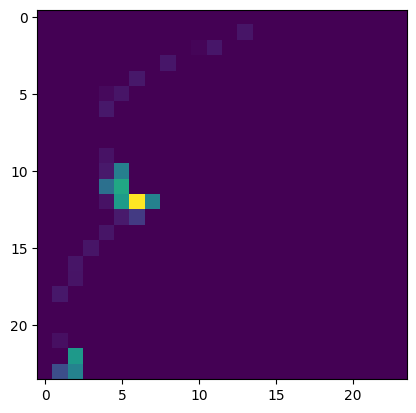

In [243]:
single_conv = convolve(training_data[0:1], single_im2col, conv_layer, conv_stride) # convolve the first training image with the first filter
single_conv = ReLU(single_conv) # apply ReLU activation function
plt.imshow(single_conv[0, 0])

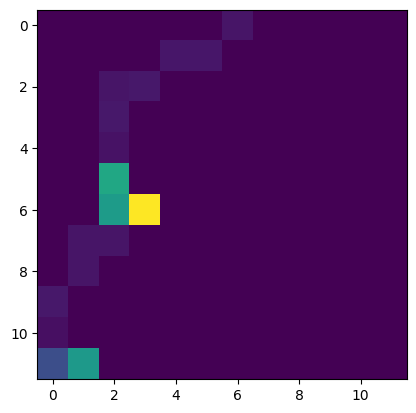

In [244]:
maxpool_size = 2
maxpool_stride = 2
single_maxpool, single_maxpool_indices = maxpool_with_indices(single_conv[0:1], maxpool_size, maxpool_stride) # maxpool the first image
plt.imshow(single_maxpool[0, 0])

In [245]:
# initialize weights and biases
W1 = np.random.rand(60, 288) / np.sqrt(288)
B0 = np.zeros((60, 1)) / np.sqrt(288)
W2 = np.random.rand(10, 60) / np.sqrt(60)
B1 = np.zeros((10, 1)) / np.sqrt(60)

In [246]:
flat_single_maxpool = single_maxpool.reshape(-1, single_maxpool.shape[0]) # flatten the output of the maxpool layer
single_fully_connected = ReLU(W1 @ flat_single_maxpool + B0) # apply the first fully connected layer
display(single_fully_connected.shape)

(60, 1)

In [247]:
single_final = np.argmax(softmax(W2 @ single_fully_connected + B1), axis=0) # apply the second fully connected layer
print("Final prediction: " + str(single_final[0]))
print("Correct label: " + str(np.argmax(training_labels[0], axis=0)))

Final prediction: 5
Correct label: 8


In [248]:

# initialize training parameters
epochs = 50
batch_size = 128
batches = int(training_data.shape[0]/batch_size)
learning_rate = 0.001

# Adam Optimizer parameters
beta1 = 0.9
beta2 = 0.995
momentum_w1 = 0
momentum_w2 = 0
momentum_b0 = 0
momentum_b1 = 0
momentum_conv1 = 0
velocity_w1 = 0
velocity_w2 = 0
velocity_b0 = 0
velocity_b1 = 0
velocity_conv1 = 0
alpha = 0.0000001

In [249]:
validation_accuries = []
for epoch_index in range(epochs):
    for batch_index in range(batches):
        start_index = batch_index * batch_size
        end_index = min(start_index + batch_size, training_data.shape[0] - 1)
        data_batch = training_data[start_index:end_index]
        label_batch = training_labels[start_index:end_index].T
        data_im2col = im2col(data_batch, conv_layer, conv_stride, 0)
        conv_res = convolve(data_batch, data_im2col, conv_layer, conv_stride)
        conv_out = ReLU(conv_res) # convolve the first training image with the first filter
        maxpool_out, maxpool_indices = maxpool_with_indices(conv_out, maxpool_size, maxpool_stride) # maxpool the first image
        flat_maxpool_out = maxpool_out.reshape(-1, maxpool_out.shape[0]) # flatten the output of the maxpool layer
        fully_connected = W1 @ flat_maxpool_out + B0 # apply the first fully connected layer
        fully_connected_out = ReLU(fully_connected) # apply ReLU activation functions
        final_connected = softmax(W2 @ fully_connected_out + B1) # apply the second fully connected layer
        
        ## back propagation
        # calculate the gradients
        delta2 = final_connected - label_batch
        delta1 = (W2.T @ delta2) * dReLU(fully_connected)
        delta0 = W1.T @ delta1
        delta_maxpool = delta0.reshape(maxpool_out.shape)
        delta_unpool = unpool_with_indices(delta_maxpool, maxpool_indices, maxpool_size) * dReLU(conv_res)
        delta_conv = (delta_unpool.transpose(1, 0, 2, 3).reshape(delta_unpool.shape[1], -1) @ data_im2col.T).reshape(conv_layer.shape)
        
        dW1 = delta1 @ flat_maxpool_out.T
        dW2 = delta2 @ fully_connected_out.T
        dB0 = np.sum(delta1, axis=1, keepdims=True)
        dB1 = np.sum(delta2, axis=1, keepdims=True)
        
        # update optimizer parameters
        momentum_w1 = beta1 * momentum_w1 + ((1 - beta1) * dW1)
        momentum_w2 = beta1 * momentum_w2 + ((1 - beta1) * dW2)
        momentum_b0 = beta1 * momentum_b0 + ((1 - beta1) * dB0)
        momentum_b1 = beta1 * momentum_b1 + ((1 - beta1) * dB1)
        momentum_conv1 = beta1 * momentum_conv1 + ((1 - beta1) * delta_conv)
        velocity_w1 = beta2 * velocity_w1 + ((1-beta2) * dW1 ** 2)
        velocity_w2 = beta2 * velocity_w2 + ((1-beta2) * dW2 ** 2)
        velocity_b0 = beta2 * velocity_b0 + ((1-beta2) * dB0 ** 2)
        velocity_b1 = beta2 * velocity_b1 + ((1-beta2) * dB1 ** 2)
        velocity_conv1 = beta2 * velocity_conv1 + ((1 - beta2) * delta_conv ** 2)
        
        # update the weights and biases
        conv_layer = conv_layer - learning_rate * momentum_conv1 / np.sqrt(velocity_conv1 + alpha)
        W1 = W1 - learning_rate * momentum_w1 / np.sqrt(velocity_w1 + alpha)
        W2 = W2 - learning_rate * momentum_w2 / np.sqrt(velocity_w2 + alpha)
        B0 = B0 - learning_rate * momentum_b0 / np.sqrt(velocity_b0 + alpha)
        B1 = B1 - learning_rate * momentum_b1 / np.sqrt(velocity_b1 + alpha)

NameError: name 'conv' is not defined